In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-ene')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading omw-ene: Package 'omw-ene' not found in
[nltk_data]     index


False

Загрузка и анализ данных

In [147]:
df = pd.read_csv('data/7282_1.csv')
df.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [99]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               35912 non-null  object 
 1   categories            35912 non-null  object 
 2   city                  35912 non-null  object 
 3   country               35912 non-null  object 
 4   latitude              35826 non-null  float64
 5   longitude             35826 non-null  float64
 6   name                  35912 non-null  object 
 7   postalCode            35857 non-null  object 
 8   province              35912 non-null  object 
 9   reviews.date          35653 non-null  object 
 10  reviews.dateAdded     35912 non-null  object 
 11  reviews.doRecommend   0 non-null      float64
 12  reviews.id            0 non-null      float64
 13  reviews.rating        35050 non-null  float64
 14  reviews.text          35888 non-null  object 
 15  reviews.title      

In [148]:
data = df.copy()
data = data[['reviews.rating', 'reviews.text', 'reviews.title']]

In [149]:
print('Размер датасета до удаления пустых строк и дубликатов:', data.shape)
data = data.dropna(subset=['reviews.text', 'reviews.rating'])
print('Размер датасета после удаления пустых строк:', data.shape)
data = data.drop_duplicates()
print('Размер датасета после удаления дубликатов:', data.shape)

Размер датасета до удаления пустых строк и дубликатов: (35912, 3)
Размер датасета после удаления пустых строк: (35026, 3)
Размер датасета после удаления дубликатов: (34432, 3)


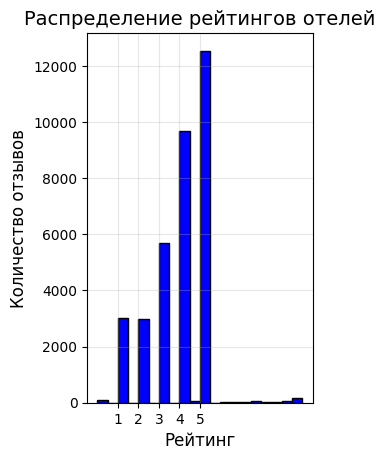

In [112]:
plt.subplot(1, 2, 1)
ratings = data['reviews.rating']
ratings.hist(bins=20, edgecolor='black', color='blue', grid=True)
plt.title('Распределение рейтингов отелей', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.xticks(range(1, 6))
plt.grid(True, alpha=0.3)

In [113]:
print(f"Всего отзывов: {len(data)}")
print(f"Минимальный рейтинг: {ratings.min():.1f}")
print(f"Максимальный рейтинг: {ratings.max():.1f}")
print(f"Средний рейтинг: {ratings.mean():.2f}")
print(f"Медианный рейтинг: {ratings.median():.2f}")
print(f"Стандартное отклонение: {ratings.std():.2f}")

Всего отзывов: 34432
Минимальный рейтинг: 0.0
Максимальный рейтинг: 10.0
Средний рейтинг: 3.80
Медианный рейтинг: 4.00
Стандартное отклонение: 1.39


In [150]:
data['text_length'] = data['reviews.text'].astype(str).apply(len)
print(f"Средняя длина отзыва: {data['text_length'].mean():.0f} символов")
print(f"Медианная длина: {data['text_length'].median():.0f} символов")
print(f"Максимальная длина: {data['text_length'].max():.0f} символов")
print(f"Минимальная длина: {data['text_length'].min():.0f} символов")

Средняя длина отзыва: 255 символов
Медианная длина: 225 символов
Максимальная длина: 3772 символов
Минимальная длина: 1 символов


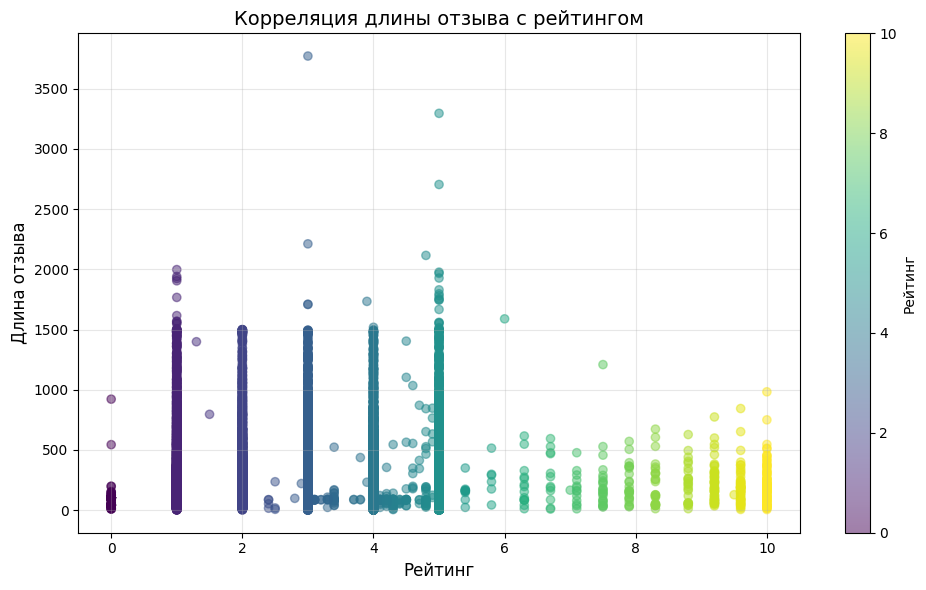

In [115]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['reviews.rating'], data['text_length'], 
                     alpha=0.5, c=data['reviews.rating'], cmap='viridis')
plt.colorbar(scatter, label='Рейтинг')
plt.title('Корреляция длины отзыва с рейтингом', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Длина отзыва', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [151]:
correlation = data['reviews.rating'].corr(data['text_length'])
print(f"Корреляция между рейтингом и длиной отзыва: {correlation:.3f}")

Корреляция между рейтингом и длиной отзыва: -0.139


Предобработка текста

In [152]:
stopwords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

texts_as_lists = []

def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^\w\s\']', ' ', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub('', text)

        text = text.lower()
        tokens = word_tokenize(text)
        filtered_tokens = [token for token in tokens if token not in stopwords]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

        unique_tokens = []
        seen_tokens = set()
        for token in lemmatized_tokens:
            if token not in seen_tokens:
                seen_tokens.add(token)
                unique_tokens.append(token)
    return ' '.join(unique_tokens)


data['full_text'] = data['reviews.title'].fillna('') + ' ' + data['reviews.text'].fillna('')
print("\nНачало предобработки текста...")
if 'full_text' in data.columns:
    tqdm.pandas()
    data['processed_text'] = data['full_text'].progress_apply(preprocess_text)
    print("Предобработка текста завершена.")
    display(data.tail())


Начало предобработки текста...


100%|██████████| 34432/34432 [00:27<00:00, 1238.50it/s]

Предобработка текста завершена.


,reviews.rating,reviews.text,reviews.title,text_length,full_text,processed_text
35905,5.0,We truly enjoyed staying at the Elk Springs re...,We Loved It!,340,We Loved It! We truly enjoyed staying at the E...,loved truly enjoyed staying elk spring resort ...
35906,5.0,We were here for a 2nd time the last weekend o...,Amazing time (both times!!),306,Amazing time (both times!!) We were here for a...,amazing time nd last weekend april stayed deer...
35907,5.0,Best of the Best!!!! My family and I stayed in...,Amazing time (both times!!),472,Amazing time (both times!!) Best of the Best!!...,amazing time best family stayed grin bear cabi...
35908,5.0,Amazing Vacation in Beautiful Cabin We stayed ...,Amazing time (both times!!),349,Amazing time (both times!!) Amazing Vacation i...,amazing time vacation beautiful cabin stayed l...
35909,5.0,My husband and I stayed at Tree Tops which is ...,Amazing time (both times!!),1448,Amazing time (both times!!) My husband and I s...,amazing time husband stayed tree top bearfoot ...


Тематическое моделирование LDA

In [118]:
count_vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 1), stop_words='english', max_df=0.9, min_df=2)
dataset = count_vectorizer.fit_transform(data['processed_text'])

lda = LDA(n_components = 8,
         max_iter=15,
         n_jobs=-1,
         learning_method='batch',
         random_state=42,
         learning_offset=50,
         doc_topic_prior=0.1,
         topic_word_prior=0.01)
lda.fit(dataset)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Тема {topic_idx + 1}:", ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

tf_feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, 12)

Тема 1: room, hotel, bed, bathroom, stay, like, dirty, night, shower, door, old, need
Тема 2: staff, stay, hotel, great, time, stayed, inn, best, service, room, year, friendly
Тема 3: hotel, location, great, restaurant, walk, walking, close, street, distance, town, nice, beach
Тема 4: room, hotel, desk, check, stay, night, got, day, told, booked, checked, time
Тема 5: room, great, stay, clean, comfortable, nice, bed, hotel, place, view, staff, night
Тема 6: staff, clean, hotel, room, good, stay, great, friendly, nice, location, breakfast, comfortable
Тема 7: breakfast, room, good, clean, nice, pool, hotel, hot, bed, coffee, free, comfortable
Тема 8: hotel, la, en, shuttle, parking, le, airport, et, personnel, car, early, el


Аналих результатов LDA

In [119]:
topic_words = {
    0: ["staff", "friendly", "room", "clean", "stay", "helpful", "great", "nice", "hotel", "desk", "comfortable", "good"],
    1: ["room", "hotel", "location", "great", "restaurant", "nice", "walking", "parking", "walk", "close", "area", "distance"],
    2: ["breakfast", "clean", "room", "stay", "staff", "great", "comfortable", "nice", "hotel", "good", "friendly", "bed"],
    3: ["room", "hotel", "bathroom", "need", "bed", "shower", "old", "good", "air", "dirty", "ac", "water"],
    4: ["good", "hotel", "stay", "great", "price", "clean", "room", "nice", "location", "breakfast", "place", "close"],
    5: ["great", "hotel", "stay", "time", "service", "view", "stayed", "place", "beautiful", "staff", "wonderful", "amazing"],
    6: ["room", "hotel", "night", "floor", "door", "noise", "like", "elevator", "stay", "people", "smoke", "outside"],
    7: ["room", "hotel", "stay", "desk", "bed", "night", "didnt", "got", "day", "told", "like", "time"]
}

manual_topic_names = {
    0: "Overall impression and service",
    1: "Rooms and amenities",
    2: "Location and accessibility",
    3: "Meals and breakfast",
    4: "Staff and service",
    5: "Cost and value",
    6: "Noise and silence",
    7: "Cleanliness and condition of the rooms"
}

short_topic_names = {
    0: "Service",
    1: "Rooms", 
    2: "Location",
    3: "Food",
    4: "Staff",
    5: "Price",
    6: "Noise",
    7: "Cleanliness"
}

for topic_id in range(8):
    print(f"\nТема {topic_id + 1}: {manual_topic_names[topic_id]}")
    print(f"Ключевые слова: {', '.join(topic_words[topic_id][:8])}...")
    print(f"Краткое название: {short_topic_names[topic_id]}")


Тема 1: Overall impression and service
Ключевые слова: staff, friendly, room, clean, stay, helpful, great, nice...
Краткое название: Service

Тема 2: Rooms and amenities
Ключевые слова: room, hotel, location, great, restaurant, nice, walking, parking...
Краткое название: Rooms

Тема 3: Location and accessibility
Ключевые слова: breakfast, clean, room, stay, staff, great, comfortable, nice...
Краткое название: Location

Тема 4: Meals and breakfast
Ключевые слова: room, hotel, bathroom, need, bed, shower, old, good...
Краткое название: Food

Тема 5: Staff and service
Ключевые слова: good, hotel, stay, great, price, clean, room, nice...
Краткое название: Staff

Тема 6: Cost and value
Ключевые слова: great, hotel, stay, time, service, view, stayed, place...
Краткое название: Price

Тема 7: Noise and silence
Ключевые слова: room, hotel, night, floor, door, noise, like, elevator...
Краткое название: Noise

Тема 8: Cleanliness and condition of the rooms
Ключевые слова: room, hotel, stay, des

In [120]:
document_topics = lda.transform(dataset)

print(f"Пример для первого отзыва: {document_topics[0]}")

data['main_topic_id'] = np.argmax(document_topics, axis=1)
data['main_topic_confidence'] = np.max(document_topics, axis=1)

data['main_topic_name'] = data['main_topic_id'].map(manual_topic_names)
data['main_topic_short'] = data['main_topic_id'].map(short_topic_names)

for topic_id in range(8):
    data[f'topic_{topic_id}_prob'] = document_topics[:, topic_id]

data.head()

Пример для первого отзыва: [0.00595376 0.00595327 0.45401071 0.00595336 0.00595374 0.00595465
 0.51026715 0.00595336]


,reviews.rating,reviews.text,reviews.title,text_length,full_text,processed_text,main_topic_id,main_topic_confidence,main_topic_name,main_topic_short,topic_0_prob,topic_1_prob,topic_2_prob,topic_3_prob,topic_4_prob,topic_5_prob,topic_6_prob,topic_7_prob
0,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,194,Good location away from the crouds Pleasant 10...,good location away crouds pleasant min walk al...,6,0.510267,Noise and silence,Noise,0.005954,0.005953,0.454011,0.005953,0.005954,0.005955,0.510267,0.005953
1,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,252,Great hotel with Jacuzzi bath! Really lovely h...,great hotel jacuzzi bath really lovely stayed ...,4,0.394927,Staff and service,Staff,0.004588,0.004588,0.004588,0.199600,0.394927,0.382532,0.004589,0.004588
2,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,136,Lugnt l��ge Ett mycket bra hotell. Det som dro...,lugnt l ge ett mycket bra hotell det som drog ...,0,0.125000,Overall impression and service,Service,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000
3,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,354,Good location on the Lido. We stayed here for ...,good location lido stayed four night october h...,5,0.502727,Cost and value,Price,0.222197,0.004034,0.004033,0.061087,0.004034,0.502727,0.197854,0.004034
4,5.0,We stayed here for four nights in October. The...,������ ���������������,354,������ ��������������� We stayed here for four...,stayed four night october hotel staff welcomin...,5,0.459448,Cost and value,Price,0.230224,0.004203,0.004203,0.064207,0.004203,0.459448,0.229308,0.004204


Тематическое моделирование NMF

In [121]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 1),
    stop_words='english',
    max_df=0.9,
    min_df=2
)

X_tfidf = tfidf_vectorizer.fit_transform(data['processed_text'])

In [124]:
nmf_model = NMF(
    n_components=8,
    init='nndsvda',
    random_state=42,
    max_iter=200,
    l1_ratio=0.5
)

W = nmf_model.fit_transform(X_tfidf)  # W: документы × темы
H = nmf_model.components_   # H: темы × слова

def display_nmf_topics(model, feature_names, no_top_words=12):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]
        
        print(f"\nТема {topic_idx + 1}:")
        for i, (word, weight) in enumerate(zip(top_words, top_weights), 1):
            print(f"  {i:2d}. {word:15s} (вес: {weight:.4f})")

In [125]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

display_nmf_topics(nmf_model, tfidf_feature_names, 12)


Тема 1:
   1. staff           (вес: 3.8080)
   2. friendly        (вес: 3.5230)
   3. helpful         (вес: 2.1274)
   4. clean           (вес: 0.5488)
   5. breakfast       (вес: 0.4705)
   6. excellent       (вес: 0.4509)
   7. accommodating   (вес: 0.3486)
   8. desk            (вес: 0.3123)
   9. room            (вес: 0.3122)
  10. extremely       (вес: 0.2847)
  11. wonderful       (вес: 0.2802)
  12. courteous       (вес: 0.2551)

Тема 2:
   1. room            (вес: 1.0711)
   2. night           (вес: 0.8851)
   3. stayed          (вес: 0.7018)
   4. like            (вес: 0.6397)
   5. desk            (вес: 0.6223)
   6. time            (вес: 0.6187)
   7. day             (вес: 0.5638)
   8. bathroom        (вес: 0.4990)
   9. check           (вес: 0.4680)
  10. bed             (вес: 0.4445)
  11. door            (вес: 0.4404)
  12. got             (вес: 0.4299)

Тема 3:
   1. stay            (вес: 3.2231)
   2. place           (вес: 2.0881)
   3. enjoyed         (вес: 0.5076)
 

Аналих результатов NMF

In [126]:
nmf_topic_words = {
    0: ["staff", "friendly", "helpful", "clean", "breakfast", "excellent", "accommodating", "desk", "room", "extremely", "wonderful", "courteous"],
    1: ["room", "night", "stayed", "like", "desk", "time", "day", "bathroom", "check", "bed", "door", "got"],
    2: ["stay", "place", "enjoyed", "definitely", "pleasant", "wonderful", "overnight", "night", "recommend", "awesome", "best", "family"],
    3: ["good", "price", "breakfast", "value", "location", "overall", "ok", "free", "food", "decent", "pretty", "money"],
    4: ["great", "location", "service", "excellent", "view", "restaurant", "perfect", "beautiful", "wonderful", "time", "loved", "food"],
    5: ["nice", "pool", "close", "room", "clean", "really", "breakfast", "quiet", "staff", "little", "people", "area"],
    6: ["comfortable", "clean", "bed", "room", "quiet", "breakfast", "convenient", "spacious", "comfy", "easy", "pillow", "large"],
    7: ["hotel", "close", "la", "restaurant", "en", "area", "da", "recommend", "excellent", "el", "located", "que"]
}

manual_nmf_topic_names = {
    0: "Staff and service",
    1: "Rooms and accommodation",
    2: "Overall experience",
    3: "Value for money",
    4: "Location and additional services",
    5: "General facilities",
    6: "Comfort and cleanliness",
    7: "Hotel overall rating"
}

short_nmf_topic_names = {
    0: "Staff",
    1: "Rooms",
    2: "Experience",
    3: "Value",
    4: "Location",
    5: "Facilities",
    6: "Comfort",
    7: "Overall"
}

for topic_id in range(8):
    print(f"\nТема {topic_id + 1}: {manual_nmf_topic_names[topic_id]}")
    print(f"Ключевые слова: {', '.join(nmf_topic_words[topic_id][:8])}...")
    print(f"Краткое название: {short_nmf_topic_names[topic_id]}")


Тема 1: Staff and service
Ключевые слова: staff, friendly, helpful, clean, breakfast, excellent, accommodating, desk...
Краткое название: Staff

Тема 2: Rooms and accommodation
Ключевые слова: room, night, stayed, like, desk, time, day, bathroom...
Краткое название: Rooms

Тема 3: Overall experience
Ключевые слова: stay, place, enjoyed, definitely, pleasant, wonderful, overnight, night...
Краткое название: Experience

Тема 4: Value for money
Ключевые слова: good, price, breakfast, value, location, overall, ok, free...
Краткое название: Value

Тема 5: Location and additional services
Ключевые слова: great, location, service, excellent, view, restaurant, perfect, beautiful...
Краткое название: Location

Тема 6: General facilities
Ключевые слова: nice, pool, close, room, clean, really, breakfast, quiet...
Краткое название: Facilities

Тема 7: Comfort and cleanliness
Ключевые слова: comfortable, clean, bed, room, quiet, breakfast, convenient, spacious...
Краткое название: Comfort

Тема 8:

In [131]:
W_normalized = W / W.sum(axis=1, keepdims=True)

data['nmf_main_topic_id'] = np.argmax(W_normalized, axis=1)
data['nmf_main_topic_confidence'] = np.max(W_normalized, axis=1)

data['nmf_main_topic_name'] = data['nmf_main_topic_id'].map(manual_nmf_topic_names)
data['nmf_main_topic_short'] = data['nmf_main_topic_id'].map(short_nmf_topic_names)

data.head()

,reviews.rating,reviews.text,reviews.title,text_length,full_text,processed_text,main_topic_id,main_topic_confidence,main_topic_name,main_topic_short,...,topic_2_prob,topic_3_prob,topic_4_prob,topic_5_prob,topic_6_prob,topic_7_prob,nmf_main_topic_id,nmf_main_topic_confidence,nmf_main_topic_name,nmf_main_topic_short
0,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,194,Good location away from the crouds Pleasant 10...,good location away crouds pleasant min walk al...,6,0.510267,Noise and silence,Noise,...,0.454011,0.005953,0.005954,0.005955,0.510267,0.005953,3,0.336061,Value for money,Value
1,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,252,Great hotel with Jacuzzi bath! Really lovely h...,great hotel jacuzzi bath really lovely stayed ...,4,0.394927,Staff and service,Staff,...,0.004588,0.199600,0.394927,0.382532,0.004589,0.004588,0,0.312159,Staff and service,Staff
2,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,136,Lugnt l��ge Ett mycket bra hotell. Det som dro...,lugnt l ge ett mycket bra hotell det som drog ...,0,0.125000,Overall impression and service,Service,...,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0,NaN,Staff and service,Staff
3,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,354,Good location on the Lido. We stayed here for ...,good location lido stayed four night october h...,5,0.502727,Cost and value,Price,...,0.004033,0.061087,0.004034,0.502727,0.197854,0.004034,6,0.288215,Comfort and cleanliness,Comfort
4,5.0,We stayed here for four nights in October. The...,������ ���������������,354,������ ��������������� We stayed here for four...,stayed four night october hotel staff welcomin...,5,0.459448,Cost and value,Price,...,0.004203,0.064207,0.004203,0.459448,0.229308,0.004204,6,0.302947,Comfort and cleanliness,Comfort


Сравнение LDA и NMF

In [136]:
print(f"Средняя уверенность, {data['main_topic_confidence'].mean()}, {data['nmf_main_topic_confidence'].mean()}")
print(f"Медианная уверенность, {data['main_topic_confidence'].median()}, {data['nmf_main_topic_confidence'].median()}")
print(f"Стандартное отклонение, {data['main_topic_confidence'].std()}, {data['nmf_main_topic_confidence'].std()}")

Средняя уверенность, 0.6447408977401341, 0.47097777754934467
Медианная уверенность, 0.6171138545825563, 0.41564095436761106
Стандартное отклонение, 0.18665259749143653, 0.19815913283539952


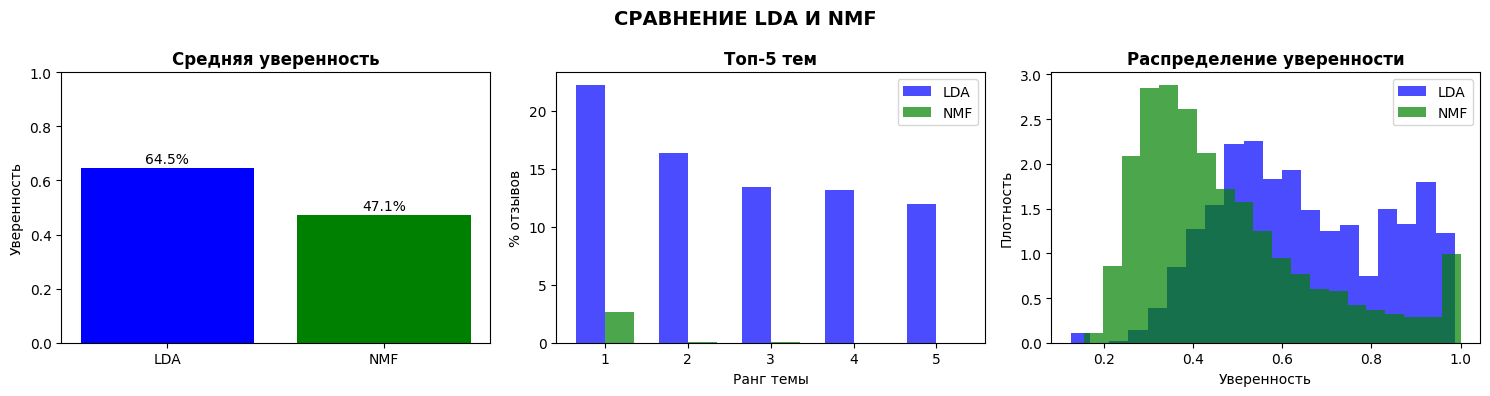

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axes[0]
methods = ['LDA', 'NMF']
confidence = [data['main_topic_confidence'].mean(), data['nmf_main_topic_confidence'].mean()]
bars = ax1.bar(methods, confidence, color=['blue', 'green'])
ax1.set_title('Средняя уверенность', fontweight='bold')
ax1.set_ylabel('Уверенность')
ax1.set_ylim(0, 1)
for bar, conf in zip(bars, confidence):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{conf:.1%}', ha='center')
    
ax2 = axes[1]
topics_lda = data['main_topic_short'].value_counts().head(5).index
counts_lda = data['main_topic_short'].value_counts().head(5).values
topics_nmf = data['nmf_main_topic_confidence'].value_counts().head(5).index
counts_nmf = data['nmf_main_topic_confidence'].value_counts().head(5).values

x = np.arange(len(topics_lda))
width = 0.35
ax2.bar(x - width/2, counts_lda/len(data)*100, width, label='LDA', color='blue', alpha=0.7)
ax2.bar(x + width/2, counts_nmf/len(data)*100, width, label='NMF', color='green', alpha=0.7)
ax2.set_title('Топ-5 тем', fontweight='bold')
ax2.set_xlabel('Ранг темы')
ax2.set_ylabel('% отзывов')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{i+1}' for i in range(5)])
ax2.legend()

ax3 = axes[2]
ax3.hist(data['main_topic_confidence'], bins=20, alpha=0.7, label='LDA', color='blue', density=True)
ax3.hist(data['nmf_main_topic_confidence'], bins=20, alpha=0.7, label='NMF', color='green', density=True)
ax3.set_title('Распределение уверенности', fontweight='bold')
ax3.set_xlabel('Уверенность')
ax3.set_ylabel('Плотность')
ax3.legend()

plt.suptitle('СРАВНЕНИЕ LDA И NMF', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()